## LSTM-Based Solana Trading Strategy (Prototype)

This project showcases a simplified long-only trading strategy on Solana cryptocurrency data, driven by a bidirectional LSTM (Long Short-Term Memory) neural network.

The model uses historical **High, Low, Close, and Volume** values at 5-minute intervals to forecast the next closing price and generate binary trading signals (buy/sell). The training process includes validation-based model selection and a basic backtesting module to compare strategy returns against passive market returns.

> 🔍 **Note**: This is **not** a production-ready trading system, but rather a prototype designed to demonstrate my ability to:
- Engineer a full deep learning pipeline in PyTorch, from raw data to backtested output
- Design and train sequence models tailored to time series data
- Apply financial evaluation metrics such as cumulative strategy returns and trade counts
- Implement clean, reusable Python/OOP code with model persistence

The architecture, trade logic, and data frequency can all be significantly enhanced. If needed, I can develop more robust, multi-factor or multi-asset strategies and integrate real-time execution layers or external data sources. This project is a technical demonstration of what's possible, not a final product.


In [1]:
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class LSTMTrader:
    def __init__(self, data_path, sequence_length=60, train_split=0.8):
        """
        Initialize the LSTMTrader class.

        Parameters:
        - data_path (str): Path to the CSV file containing the data.
        - sequence_length (int): Number of past observations to use for predicting the next value.
        - train_split (float): Proportion of data to use for training.
        """
        self.data_path = data_path
        self.sequence_length = sequence_length
        self.train_split = train_split

        self.scaler = None  # Will be set later
        self.model = None
        self.train_losses = []
        self.val_losses = []
        self.strategy_returns = []

        # Data placeholders
        self.data = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.predictions = None
        self.y_test_unscaled = None
        self.backtest_data = None

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def load_data(self):
        """Load and preprocess the data from the CSV file."""
        # Load data
        self.data = pd.read_csv(self.data_path)
        # Use Timestamp, High, Low, Close, Volume
        self.data = self.data[['Timestamp', 'High', 'Low', 'Close', 'Volume']]
        self.data.set_index('Timestamp', inplace=True)
        print("Data loaded successfully with columns:", self.data.columns.tolist())

    def preprocess_data(self):
        """
        Scale the data (High, Low, Close, Volume) and create training, validation, and testing datasets.
        
        We'll predict the next 'Close' value (i.e., the 3rd column in the scaled data).
        """
        # If scaler not fitted, create a new one and fit on entire dataset
        if not self.scaler:
            self.scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = self.scaler.fit_transform(self.data)
        else:
            scaled_data = self.scaler.transform(self.data)

        # Create sequences
        # X: shape (sequence_length, 4), y: next close (column index 2)
        X = []
        y = []
        for i in range(self.sequence_length, len(scaled_data)):
            # Take the previous 'sequence_length' rows of ALL features (High, Low, Close, Volume)
            X.append(scaled_data[i - self.sequence_length:i, :])  # shape = (sequence_length, 4)
            # Predict the next Close => scaled_data[i, 2]
            y.append(scaled_data[i, 2])

        X = np.array(X)
        y = np.array(y)

        # Split into training, validation, and testing sets
        total_length = len(X)
        train_size = int(self.train_split * total_length)
        val_size = int(0.1 * total_length)  # 10% for validation
        test_size = total_length - train_size - val_size

        self.X_train = torch.from_numpy(X[:train_size]).float()
        self.y_train = torch.from_numpy(y[:train_size]).float()
        self.X_val = torch.from_numpy(X[train_size:train_size + val_size]).float()
        self.y_val = torch.from_numpy(y[train_size:train_size + val_size]).float()
        self.X_test = torch.from_numpy(X[train_size + val_size:]).float()
        self.y_test = torch.from_numpy(y[train_size + val_size:]).float()

        print(f"Data preprocessing completed. "
              f"Train samples: {train_size}, Val samples: {val_size}, Test samples: {test_size}")

    def build_model(self):
        """Build the Bidirectional LSTM model that handles 4 input features."""
        class LSTMModel(nn.Module):
            def __init__(self):
                super(LSTMModel, self).__init__()
                # Since we have 4 features: input_size = 4
                self.lstm1 = nn.LSTM(input_size=4, hidden_size=50, batch_first=True, bidirectional=True)
                self.dropout1 = nn.Dropout(0.1)
                # The output of the first LSTM is 2*hidden_size = 100 (bidirectional)
                self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True, bidirectional=True)
                self.dropout2 = nn.Dropout(0.1)
                # Final FC layer => 2*hidden_size => 1
                self.fc = nn.Linear(100, 1)

            def forward(self, x):
                out, _ = self.lstm1(x)         # out shape: (batch, seq, 2*hidden_size=100)
                out = self.dropout1(out)
                out, _ = self.lstm2(out)       # still (batch, seq, 100)
                out = self.dropout2(out)
                # Take the output at the last time step
                out = out[:, -1, :]  # (batch, 100)
                out = self.fc(out)   # (batch, 1)
                return out

        self.model = LSTMModel().to(self.device)
        print("Model built successfully with input_size=4 for High, Low, Close, Volume.")

    def train_model(self, epochs=5, batch_size=32):
        """
        Train the model on the training data using the GPU.

        Parameters:
        - epochs (int): Number of epochs to train the model.
        - batch_size (int): Batch size for training.
        """
        # Prepare data loaders
        train_dataset = torch.utils.data.TensorDataset(self.X_train, self.y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = torch.utils.data.TensorDataset(self.X_val, self.y_val)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.0005)

        self.model.train()
        self.train_losses = []
        self.val_losses = []
        self.strategy_returns = []
        best_strategy_return = float('-inf')
        best_model_state = None

        for epoch in range(epochs):
            start_time = time.time()
            epoch_loss = 0.0
            for inputs, targets in train_loader:
                inputs = inputs.to(self.device)   # (batch_size, seq_length, 4)
                targets = targets.to(self.device) # (batch_size, )

                # Reshape for LSTM => already (batch, seq, features), so just unsqueeze if needed:
                # In this setup, it's already shape (batch, seq_length, 4), no extra unsqueeze needed.
                # If it were shape (batch, seq_length), you'd do inputs = inputs.unsqueeze(-1).

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)

            avg_loss = epoch_loss / len(train_loader.dataset)
            self.train_losses.append(avg_loss)

            # Evaluate on validation set
            val_loss = self.evaluate_validation_loss(val_loader, criterion)
            self.val_losses.append(val_loss)

            # Backtest strategy on validation set
            strategy_return, number_of_trades = self.backtest_on_validation()
            self.strategy_returns.append(strategy_return)

            # Save model if it's the best so far
            if strategy_return > best_strategy_return:
                best_strategy_return = strategy_return
                best_model_state = self.model.state_dict()

            epoch_time = time.time() - start_time
            print(f"Epoch {epoch + 1}/{epochs}, "
                  f"Train Loss: {avg_loss:.7f}, "
                  f"Val Loss: {val_loss:.7f}, "
                  f"Strategy Return: {strategy_return:.2%}, "
                  f"Number of Trades: {number_of_trades}, "
                  f"Time: {epoch_time:.2f}s")

        # Load the best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"Best model loaded with strategy return: {best_strategy_return:.2%}")

        print("Model training completed.")

    def evaluate_validation_loss(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                outputs = self.model(inputs)  # shape (batch, 1)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item() * inputs.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        self.model.train()
        return avg_val_loss

    def backtest_on_validation(self):
        """Backtest the strategy on the validation set and return cumulative strategy return and number of trades."""
        self.model.eval()
        predictions = []
        actuals = []

        val_dataset = torch.utils.data.TensorDataset(self.X_val, self.y_val)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())

        predictions = np.array(predictions)
        # predictions shape => (val_samples, 1)
        # 'Close' is column index = 2 in the original scaling
        # We'll re-insert dummy columns for High(0), Low(1), Volume(3) if needed
        # For a simpler approach, do inverse_transform on just the close column:

        # We create a dummy array of shape (val_samples, 4) so we can inverse_transform properly:
        dummy = np.zeros((predictions.shape[0], 4))
        dummy[:, 2] = predictions[:, 0]  # place predictions in the 'Close' spot
        predictions_unscaled = self.scaler.inverse_transform(dummy)[:, 2]

        # actuals are the scaled close, so we do the same trick:
        dummy_actuals = np.zeros((len(actuals), 4))
        dummy_actuals[:, 2] = actuals
        actuals_unscaled = self.scaler.inverse_transform(dummy_actuals)[:, 2]

        # Generate trading signals
        signal = []
        for i in range(len(predictions_unscaled)):
            if predictions_unscaled[i] > actuals_unscaled[i]:
                signal.append(1)  # Buy
            else:
                signal.append(0)  # Sell

        # Create DataFrame for backtesting
        backtest_data = pd.DataFrame({
            'Actual_Price': actuals_unscaled,
            'Predicted_Price': predictions_unscaled,
            'Signal': signal
        })

        # Calculate returns
        backtest_data['Returns'] = backtest_data['Actual_Price'].pct_change()
        backtest_data['Strategy_Returns'] = backtest_data['Returns'] * pd.Series(signal).shift(1)

        # Calculate cumulative returns
        backtest_data['Cumulative_Strategy_Returns'] = (1 + backtest_data['Strategy_Returns']).cumprod()

        # Final cumulative strategy return
        strategy_return = backtest_data['Cumulative_Strategy_Returns'].iloc[-1] - 1

        # Number of trades
        number_of_trades = ((backtest_data['Signal'].shift(1) == 1) & (backtest_data['Signal'] == 0)).sum()

        self.model.train()
        return strategy_return, number_of_trades

    def evaluate_model(self, batch_size=512):
        """Evaluate the model on the test set and print performance metrics."""
        self.model.eval()
        predictions = []
        actuals = []

        test_dataset = torch.utils.data.TensorDataset(self.X_test, self.y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(inputs)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())

        # Convert to numpy
        predictions = np.array(predictions)  # shape => (test_samples, 1)
        # We must invert the scale for the close column only
        dummy = np.zeros((predictions.shape[0], 4))
        dummy[:, 2] = predictions[:, 0]
        self.predictions = self.scaler.inverse_transform(dummy)[:, 2]

        dummy_actuals = np.zeros((len(actuals), 4))
        dummy_actuals[:, 2] = actuals
        self.y_test_unscaled = self.scaler.inverse_transform(dummy_actuals)[:, 2].reshape(-1, 1)

        # Metrics
        mse = mean_squared_error(self.y_test_unscaled, self.predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_test_unscaled, self.predictions)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")

    def backtest_strategy(self):
        """Perform backtesting of the trading strategy based on predictions on the test set."""
        signal = []
        for i in range(len(self.predictions)):
            if self.predictions[i] > self.y_test_unscaled[i]:
                signal.append(1)  # Buy
            else:
                signal.append(0)  # Sell

        self.backtest_data = pd.DataFrame({
            'Actual_Price': self.y_test_unscaled.flatten(),
            'Predicted_Price': self.predictions.flatten(),
            'Signal': signal
        })

        self.backtest_data['Returns'] = self.backtest_data['Actual_Price'].pct_change()
        self.backtest_data['Strategy_Returns'] = self.backtest_data['Returns'] * pd.Series(signal).shift(1)

        self.backtest_data['Cumulative_Market_Returns'] = (1 + self.backtest_data['Returns']).cumprod()
        self.backtest_data['Cumulative_Strategy_Returns'] = (1 + self.backtest_data['Strategy_Returns']).cumprod()

        market_return = self.backtest_data['Cumulative_Market_Returns'].iloc[-1] - 1
        strategy_return = self.backtest_data['Cumulative_Strategy_Returns'].iloc[-1] - 1

        print(f"Cumulative Market Return: {market_return:.2%}")
        print(f"Cumulative Strategy Return: {strategy_return:.2%}")

    def save_model(self, model_path='solana_only_long.pth', scaler_path='scale_only_long.pkl'):
        """Save the trained model and scaler to files."""
        torch.save(self.model.state_dict(), model_path)
        import joblib
        joblib.dump(self.scaler, scaler_path)
        print(f"Model saved to {model_path}.")
        print(f"Scaler saved to {scaler_path}.")

    def load_model(self, model_path='solana_only_long.pth', scaler_path='scale_only_long.pkl'):
        """Load a pre-trained model and scaler from files."""
        self.build_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)
        self.model.eval()
        import joblib
        self.scaler = joblib.load(scaler_path)
        print(f"Model loaded from {model_path}.")
        print(f"Scaler loaded from {scaler_path}.")

    def plot_loss(self):
        """Plot the training and validation loss over epochs."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_strategy_returns(self):
        """Plot the cumulative strategy returns over epochs."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.strategy_returns, label='Strategy Return')
        plt.title('Strategy Return Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Cumulative Strategy Return')
        plt.legend()
        plt.show()

    def plot_predictions(self):
        """Plot the actual vs. predicted prices on the test set."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.y_test_unscaled, label='Actual Price')
        plt.plot(self.predictions, label='Predicted Price')
        plt.title('Price Prediction on Test Set')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def plot_cumulative_returns(self):
        """Plot the cumulative returns of the market and the strategy on the test set."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.backtest_data['Cumulative_Market_Returns'], label='Market Returns')
        plt.plot(self.backtest_data['Cumulative_Strategy_Returns'], label='Strategy Returns')
        plt.title('Cumulative Returns on Test Set')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.show()


In [2]:
# Instantiate the class
trader = LSTMTrader(data_path='SOL_5min_OHLC_UTC.csv', sequence_length=20, train_split=0.8)

In [3]:
# Load and preprocess the data
trader.load_data()
trader.preprocess_data()

Data loaded successfully with columns: ['High', 'Low', 'Close', 'Volume']
Data preprocessing completed. Train samples: 377166, Val samples: 47145, Test samples: 47147


In [4]:
# Build and train the model
trader.build_model()
trader.train_model(epochs=50, batch_size=1024)
# Save the model
trader.save_model('solana_only_long.pth', 'scale_only_long.pkl')

Model built successfully with input_size=4 for High, Low, Close, Volume.
Epoch 1/50, Train Loss: 0.0041147, Val Loss: 0.0000131, Strategy Return: 0.21%, Number of Trades: 2185, Time: 34.77s
Epoch 2/50, Train Loss: 0.0002349, Val Loss: 0.0000086, Strategy Return: -19.01%, Number of Trades: 3754, Time: 33.25s
Epoch 3/50, Train Loss: 0.0001849, Val Loss: 0.0000086, Strategy Return: -24.75%, Number of Trades: 3805, Time: 32.79s
Epoch 4/50, Train Loss: 0.0001588, Val Loss: 0.0000126, Strategy Return: 18.17%, Number of Trades: 2249, Time: 37.79s
Epoch 5/50, Train Loss: 0.0001388, Val Loss: 0.0000125, Strategy Return: -8.30%, Number of Trades: 2429, Time: 51.14s
Epoch 6/50, Train Loss: 0.0001282, Val Loss: 0.0000090, Strategy Return: -24.52%, Number of Trades: 3606, Time: 42.18s
Epoch 7/50, Train Loss: 0.0001166, Val Loss: 0.0000485, Strategy Return: 53.97%, Number of Trades: 422, Time: 32.44s
Epoch 8/50, Train Loss: 0.0001080, Val Loss: 0.0000093, Strategy Return: -42.40%, Number of Trades: 

In [5]:
#trader.load_model()

In [6]:
# Evaluate the model
trader.evaluate_model(batch_size=512)

MSE: 1.6047230885358594
RMSE: 1.2667766529802558
MAE: 0.8834099267255773


In [7]:
# Backtest the trading strategy
trader.backtest_strategy()

Cumulative Market Return: 30.15%
Cumulative Strategy Return: 85.74%


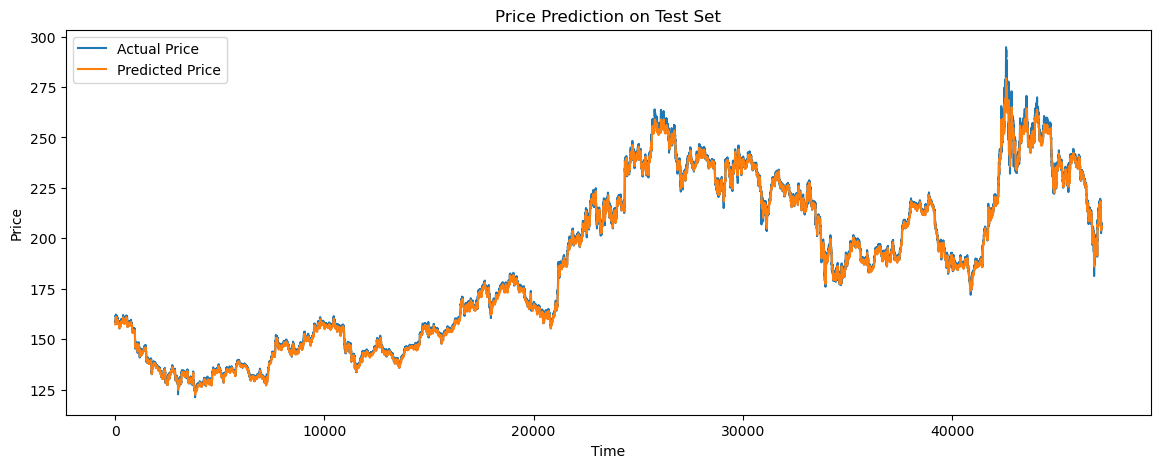

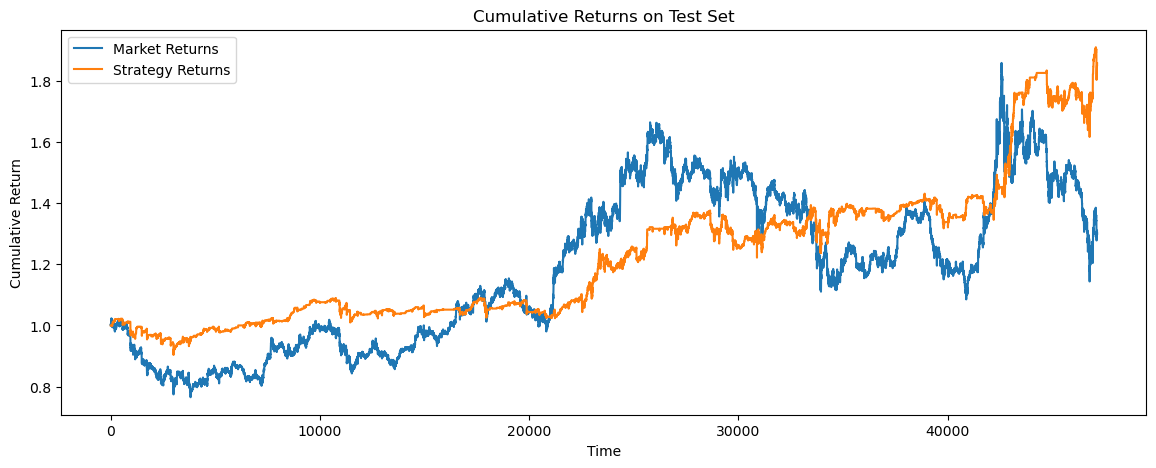

In [8]:
# Plot results
trader.plot_predictions()
trader.plot_cumulative_returns()

In [9]:
# Evaluate the model
trader.evaluate_model(batch_size=512)

MSE: 1.6047230885358594
RMSE: 1.2667766529802558
MAE: 0.8834099267255773


## Conclusion: Simple Model, Strong Signal

This prototype demonstrates how even a relatively simple deep learning architecture—built around a two-layer bidirectional LSTM and basic trading logic—can outperform the market in backtesting.

By training on just 5-minute candlestick data (High, Low, Close, Volume) and using a basic directional strategy, the model achieved **higher cumulative returns** than the passive buy-and-hold approach on the test set. This suggests that even low-complexity models can learn meaningful structure from raw price patterns.

While this strategy is far from production-ready, it highlights several important points:

- **Deep learning is capable of capturing short-term predictive structure** in financial time series, even without external signals or labels.
- **Custom models, richer features, and more sophisticated logic** (e.g., risk management, position sizing, shorting, portfolio allocation) would likely improve results significantly.
- **Backtesting and evaluation frameworks** are critical for measuring not just prediction quality, but actual strategy viability.

This project is meant as a self-contained demonstration of technical workflow and modeling strategy—not a production system—but it shows the kind of structured experimentation I can bring to more complex use cases.
